# Bike sharing demand forecast (on daily data)

Predict bike sharing demand as a function of seasonal and weather conditions.

Data origin:
- original full dataset (by hour, not used here): https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
- simplified dataset (by day, with some simple scaling): https://www.hds.utc.fr/~tdenoeux/dokuwiki/en/aec
    - description: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/exam_2019_ace_.pdf
    - data: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/bike_sharing_day.csv.zip
    
Note that even if we are estimating a time serie, we are not using here a recurrent neural network as we assume the temporal dependence to be negligible (i.e. Y_t = f(X_t) alone).

In [1]:
###########################################################################################
### With scaling of the X, correction of measure unit for Y & dummification (but no PCA)...
###########################################################################################
using Pkg
function addIfNeeded(pkgs...)
    isinstalled(pkg::String) = any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
    [Pkg.add(pkg) for pkg in pkgs  if !isinstalled(pkg)]
end

addIfNeeded("DataFrames","CSV","StatsPlots","Distributions","BetaML")

using LinearAlgebra, Random, Statistics, DataFrames, CSV, StatsPlots, BetaML.Nn
import Distributions: Uniform

import Random:seed!
seed!(123)

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1260
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1260
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1260
┌ Info: Precompiling BetaML [024491cd-cc6b-443e-8034-08ea7eb7db2b]
└ @ Base loading.jl:1260


MersenneTwister(UInt32[0x0000007b], Random.DSFMT.DSFMT_state(Int32[1464307935, 1073116007, 222134151, 1073120226, -290652630, 1072956456, -580276323, 1073476387, 1332671753, 1073438661  …  138346874, 1073030449, 1049893279, 1073166535, -1999907543, 1597138926, -775229811, 32947490, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000000

In [4]:
using BetaML  # only needed to get the relative path in importing data
baseDir = joinpath(dirname(pathof(BetaML)),"..","notebooks","assets","bikeSharingDemandForecast")

"/home/lobianco/.julia/dev/BetaML/src/../notebooks/assets/bikeSharingDemandForecast"

In [5]:
# Data loading and cleaning..
data = CSV.File(joinpath(baseDir,"bike_sharing_day.csv"),delim=',') |> DataFrame
describe(data)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,instant,366.0,1,366.0,731,0,Int64
2,dteday,,2011-01-01,,2012-12-31,0,Date
3,season,2.49658,1,3.0,4,0,Int64
4,yr,0.500684,0,1.0,1,0,Int64
5,mnth,6.51984,1,7.0,12,0,Int64
6,holiday,0.0287278,0,0.0,1,0,Int64
7,weekday,2.99726,0,3.0,6,0,Int64
8,workingday,0.683995,0,1.0,1,0,Int64
9,weathersit,1.39535,1,1.0,3,0,Int64


In [6]:
seasonDummies  = convert(Array{Float64,2},onehotencoder(data[:,:season]))
weatherDummies = convert(Array{Float64,2},onehotencoder(data[:,:weathersit]))
wdayDummies    = convert(Array{Float64,2},onehotencoder(data[:,:weekday] .+ 1 ))

x    = convert(Matrix,hcat(convert(Array{Float64,2},data[:,[:instant,:yr,:mnth,:holiday,:workingday,:temp,:atemp,:hum,:windspeed]]),
            seasonDummies,
            weatherDummies,
            wdayDummies))
y    = data[:,16] 
colsNotToScale = [2;4;5;10:23]

# Split the data in training/testing sets
((xtrain,xval,xtest),(ytrain,yval,ytest)) = BetaML.Utils.partition([x,y],[0.75,0.125,1-0.75-0.125],shuffle=false)
(ytrain,yval,ytest)   = dropdims.([ytrain,yval,ytest],dims=2)
(ntrain, nval, ntest) = size.([ytrain,yval,ytest],1)


xScaleFactors   = get_scalefactors(xtrain,skip=colsNotToScale)
yScaleFactors   = ([0],[0.001]) # get_scalefactors(ytrain) # This just divide by 1000. Using full scaling of Y we may get negative demand.
xtrainScaled    = scale(xtrain,xScaleFactors)
xvalScaled      = scale(xval,xScaleFactors)
xtestScaled     = scale(xtest,xScaleFactors)
ytrainScaled    = scale(ytrain,yScaleFactors)
out             = pca(xtrainScaled,error=0.05)
xtrainScaledPca = xtrainScaled #out.X  # change these lines if you want to run PCA (doesn't seem to improve)
xvalScaledPca   = xvalScaled   #xvalScaled*out.P
xtestScaledPca  = xtestScaled  #xtestScaled*out.P
D = size(xtrainScaledPca,2)

23

In [7]:
# Train using validation set to select the hyperpharameters (may take a while)
epochsToTest     = [10,20,40,80,160,320,640,1200]
hiddenLayerSizes = [5,8,12,15,20,25,30]
bestEpoch        = 0
bestSize         = 0
bestValError     = Inf
errorsMatrix     = fill(Inf64,length(epochsToTest),length(hiddenLayerSizes))

for (ne,epoch) in enumerate(epochsToTest), (nls,ls) in enumerate(hiddenLayerSizes)

    global bestValError, bestSize, errorsMatrix, bestEpoch
    println("Testing epochs $epoch, layer size $ls ...")
    # Note that the Xavier initialisation is now by default, so you don't need to specify w and wb to get it...
    l1   = DenseLayer(D,ls,f=sigmoid, w=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls,D), wb=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls)   ) # Activation function is ReLU
    l2   = DenseLayer(ls,1,f=relu, w=rand(Uniform(-sqrt(6)/sqrt(1+15),sqrt(6)/sqrt(1+15)),1,ls), wb=rand(Uniform(-sqrt(6)/sqrt(ls+1),sqrt(6)/sqrt(ls+1)),1) )
    mynn = buildNetwork([l1,l2],squared_cost,name="Bike sharing regression model") # Build the NN and use the squared cost (aka MSE) as error function

    # Training it (default to ADAM)
    res  = train!(mynn,xtrainScaledPca,ytrainScaled,epochs=epoch,batch_size=8,opt_alg=ADAM(),verbosity=NONE) # Use opt_alg=SGD() to use Stochastic Gradient Descent
    ŷval = scale(predict(mynn,xvalScaledPca),yScaleFactors,rev=true)
    
    mean_relative_errorVal  = relative_mean_error(ŷval,yval)
    if mean_relative_errorVal < bestValError
        bestValError = mean_relative_errorVal
        bestSize     = ls
        bestEpoch    = epoch
    end
    errorsMatrix[ne,nls] = mean_relative_errorVal
end

errorsMatrix

Testing epochs 10, layer size 5 ...
Testing epochs 10, layer size 8 ...
Testing epochs 10, layer size 12 ...
Testing epochs 10, layer size 15 ...
Testing epochs 10, layer size 20 ...
Testing epochs 10, layer size 25 ...
Testing epochs 10, layer size 30 ...
Testing epochs 20, layer size 5 ...
Testing epochs 20, layer size 8 ...
Testing epochs 20, layer size 12 ...
Testing epochs 20, layer size 15 ...
Testing epochs 20, layer size 20 ...
Testing epochs 20, layer size 25 ...
Testing epochs 20, layer size 30 ...
Testing epochs 40, layer size 5 ...
Testing epochs 40, layer size 8 ...
Testing epochs 40, layer size 12 ...
Testing epochs 40, layer size 15 ...
Testing epochs 40, layer size 20 ...
Testing epochs 40, layer size 25 ...
Testing epochs 40, layer size 30 ...
Testing epochs 80, layer size 5 ...
Testing epochs 80, layer size 8 ...
Testing epochs 80, layer size 12 ...
Testing epochs 80, layer size 15 ...
Testing epochs 80, layer size 20 ...
Testing epochs 80, layer size 25 ...
Testing e

8×7 Array{Float64,2}:
 0.570205  0.388614  1.0       1.0       0.161129  0.153347  0.132998
 0.280792  0.203554  0.199366  0.153142  0.142102  0.141285  0.131965
 0.176258  0.152069  1.0       0.125781  0.134068  0.131639  0.129514
 0.12306   0.124536  0.119029  0.116175  0.119494  0.113377  1.0
 0.126974  0.111698  0.109896  0.125371  0.111569  1.0       0.134093
 0.144599  0.107859  0.10633   0.139752  0.117788  0.131807  1.0
 0.16126   0.136599  1.0       0.157485  0.141403  0.167792  0.16264
 0.185882  0.118368  0.118064  0.138479  0.165465  0.133723  0.116669

In [8]:
# Re-doing training with the best hyperparameters:
ls    = bestSize
epoch = bestEpoch

println("Final training of $epoch epochs, with layer size $ls ...")
# Note that the Xavier initialisation is now by default, so you don't need to specify w and wb to get it...
l1   = DenseLayer(D,ls,f=sigmoid, w=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls,D), wb=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls)   ) # Activation function is ReLU
l2   = DenseLayer(ls,1,f=identity, w=rand(Uniform(-sqrt(6)/sqrt(1+15),sqrt(6)/sqrt(1+15)),1,ls), wb=rand(Uniform(-sqrt(6)/sqrt(ls+1),sqrt(6)/sqrt(ls+1)),1) )
mynn = buildNetwork([l1,l2],squared_cost,name="Bike sharing regression model") # Build the NN and use the squared cost (aka MSE) as error function

# Training it (default to ADAM)
res  = train!(mynn,xtrainScaledPca,ytrainScaled,epochs=epoch,batch_size=8,opt_alg=ADAM()) # Use opt_alg=SGD() to use Stochastic Gradient Descent

Final training of 320 epochs, with layer size 12 ...
***
*** Training Bike sharing regression model for 320 epochs with algorithm ADAM.
Training.. 	 avg ϵ on (Epoch 1 Batch 68): 	 3.614306148395766
Training.. 	 avg ϵ on (Epoch 32 Batch 68): 	 0.08508164201806433


Training the Neural Network... 14%|███                  |  ETA: 0:00:06

Training.. 	 avg ϵ on (Epoch 64 Batch 68): 	 0.1484287641736479
Training.. 	 avg ϵ on (Epoch 96 Batch 68): 	 0.12014072103772235


Training the Neural Network... 33%|███████              |  ETA: 0:00:05

Training.. 	 avg ϵ on (Epoch 128 Batch 68): 	 0.035920359408849384


Training the Neural Network... 49%|██████████▎          |  ETA: 0:00:04

Training.. 	 avg ϵ on (Epoch 160 Batch 68): 	 0.0620914361169687
Training.. 	 avg ϵ on (Epoch 192 Batch 68): 	 0.15202971996440462


Training the Neural Network... 65%|█████████████▋       |  ETA: 0:00:02

Training.. 	 avg ϵ on (Epoch 224 Batch 68): 	 0.11186545404362552


Training the Neural Network... 81%|█████████████████    |  ETA: 0:00:01

Training.. 	 avg ϵ on (Epoch 256 Batch 68): 	 0.18080495509307545
Training.. 	 avg ϵ on (Epoch 288 Batch 68): 	 0.13052984131646148


Training the Neural Network...100%|█████████████████████| Time: 0:00:06


Training.. 	 avg ϵ on (Epoch 320 Batch 68): 	 0.03728312785769604
Training of 320 epoch completed. Final epoch error: 0.0804768833021858.


(epochs = 320, ϵ_epochs = [9.182473834692267, 6.400316152298417, 4.483615178189874, 3.16614591542958, 2.2733372889848025, 1.683089710253344, 1.2961487587528842, 1.0405699452602197, 0.8580738770332355, 0.7259129824524282  …  0.08149581479167123, 0.08140522430130555, 0.08131144910655279, 0.08113630039661196, 0.08103760974414621, 0.08096841592439744, 0.08091533083955978, 0.08068864639049265, 0.08059882119186444, 0.0804768833021858], θ_epochs = Any[])

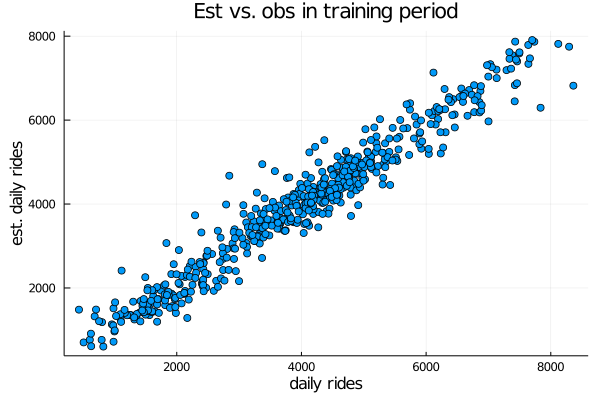

In [9]:
ŷtrain  = max.(0.0,scale(predict(mynn,xtrainScaledPca),yScaleFactors,rev=true))
scatter(ytrain,ŷtrain,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in training period")

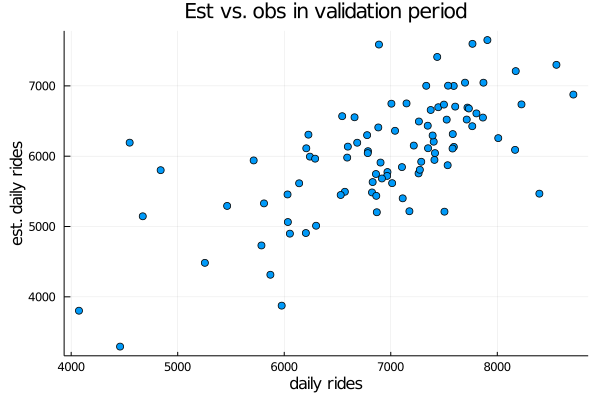

In [10]:
ŷval = max.(0.0,scale(predict(mynn,xvalScaledPca),yScaleFactors,rev=true))
scatter(yval,ŷval,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in validation period")

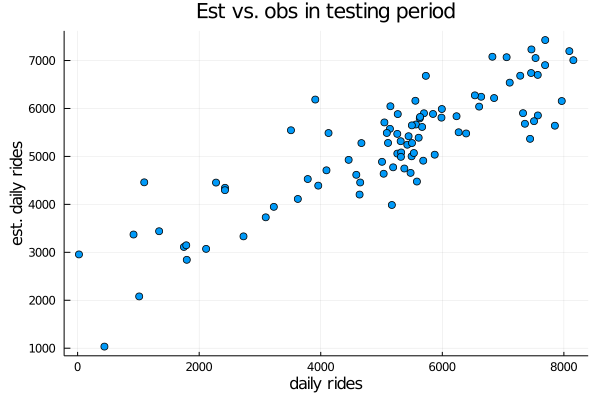

In [11]:
ŷtest  = max.(0.0,scale(predict(mynn,xtestScaledPca),yScaleFactors,rev=true))
scatter(ytest,ŷtest,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in testing period")

In [12]:
mean(abs.(ŷtest .- ytest))/mean(ytest)

0.15586315948123605

In [14]:
(mreTrain, mreVal, mreTest) = mean_relative_error.([ŷtrain,ŷval,ŷtest],[ytrain,yval,ytest])

3-element Array{Float64,1}:
 0.09813949515969443
 0.14385803523673368
 1.726981031035195

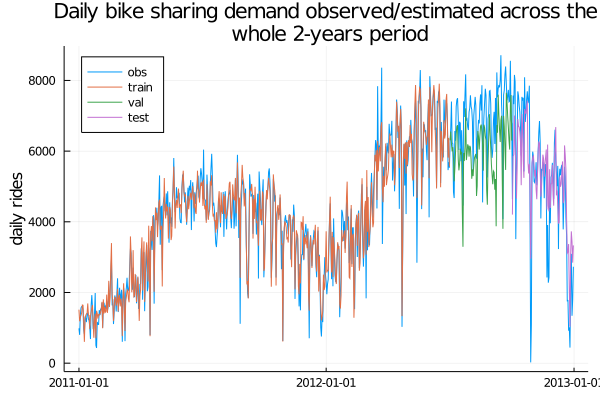

In [15]:
# Full period plot (2 years)
ŷtrainfull = vcat(ŷtrain,fill(missing,nval+ntest))
ŷvalfull   = vcat(fill(missing,ntrain), ŷval, fill(missing,ntest))
ŷtestfull  = vcat(fill(missing,ntrain+nval), ŷtest)
plot(data[:,:dteday],[data[:,:cnt] ŷtrainfull ŷvalfull ŷtestfull], label=["obs" "train" "val" "test"], legend=:topleft, ylabel="daily rides", title="Daily bike sharing demand observed/estimated across the\n whole 2-years period")

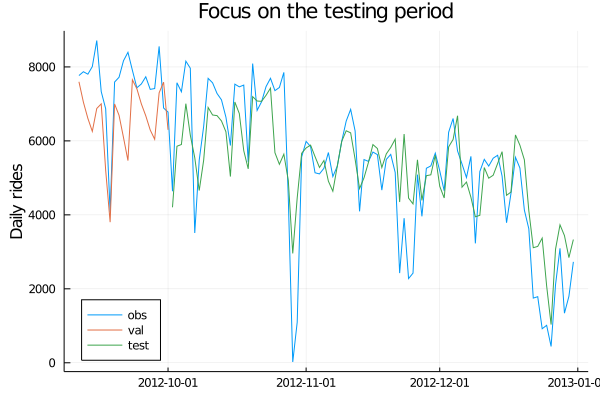

In [16]:
# Focus on testing data
stc  = 620
endc = size(x,1)
plot(data[stc:endc,:dteday],[data[stc:endc,:cnt] ŷvalfull[stc:endc] ŷtestfull[stc:endc]], label=["obs" "val" "test"], legend=:bottomleft, ylabel="Daily rides", title="Focus on the testing period")

## Comparation with Flux

Disclaimer: I'm a nebbie with [Flux](https://fluxml.ai/), this is likelly not to be the best approach

In [32]:
using Flux

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1260
┌ Warning: Module Zygote with build ID 246192043980865 is missing from the cache.
│ This may mean Zygote [e88e6eb3-aa80-5325-afca-941959d7151f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1016
┌ Info: Skipping precompilation since __precompile__(false). Importing Flux [587475ba-b771-5e3f-ad9e-33799f191a9c].
└ @ Base loading.jl:1033
┌ Info: Precompiling CUDA [052768ef-5323-5732-b1bb-66c8b64840ba]
└ @ Base loading.jl:1260
┌ Info: Precompiling Functors [d9f16b24-f501-4c13-a1f2-28368ffc5196]
└ @ Base loading.jl:1260
┌ Info: Precompiling CodecZlib [944b1d66-785c-5afd-91f1-9de20f533193]
└ @ Base loading.jl:1260
┌ Info: Precompiling ZipFile [a5390f91-8eb1-5f08-bee0-b1d1ffed6cea]
└ @ Base loading.jl:1260


In [33]:
# Defining the net model and load it with data...
Flux_nn = Chain(Dense(D,ls,Flux.sigmoid),
                Dense(ls,1,identity))

loss(x, y) = Flux.mse(Flux_nn(x), y)
ps         = Flux.params(Flux_nn)
nndata     = Flux.Data.DataLoader(xtrainScaledPca', ytrainScaled', batchsize=8,shuffle=true) 

┌ Warning: `DataLoader(x...; kws...)` is deprecated, use `DataLoader(x; kws...)` instead.
│   caller = ip:0x0
└ @ Core :-1


Flux.Data.DataLoader{Tuple{Adjoint{Float64,Array{Float64,2}},Adjoint{Float64,Array{Float64,1}}}}(([-1.728893009486523 -1.722571645649278 … 1.722571645649278 1.728893009486523; 0.0 0.0 … 1.0 1.0; … ; 0.0 0.0 … 0.0 0.0; 1.0 0.0 … 1.0 0.0], [0.985 0.801 … 5.687 5.531]), 8, 548, true, 548, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  539, 540, 541, 542, 543, 544, 545, 546, 547, 548], true)

In [34]:
# Training of the Flux model...
Flux.@epochs epoch Flux.train!(loss, ps, nndata, Flux.ADAM(0.001, (0.9, 0.8)))

┌ Info: Epoch 1
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 2
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 3
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 4
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 5
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 6
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 7
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 8
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 9
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 10
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 11
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/s

┌ Info: Epoch 89
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 90
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 91
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 92
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 93
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 94
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 95
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 96
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 97
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 98
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 99
└ @ Main /home/lobianco/.julia/packages/Flu

┌ Info: Epoch 181
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 182
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 183
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 184
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 185
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 186
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 187
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 188
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 189
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 190
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 191
└ @ Main /home/lobianco/.julia/p

┌ Info: Epoch 273
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 274
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 275
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 276
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 277
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 278
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 279
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 280
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 281
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 282
└ @ Main /home/lobianco/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 283
└ @ Main /home/lobianco/.julia/p

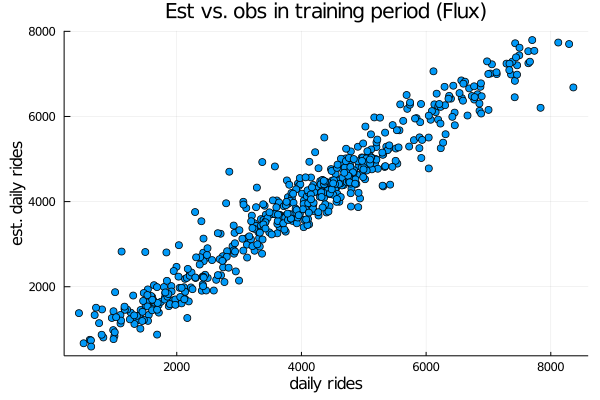

In [35]:
ŷtrainf = max.(0.0,scale(Flux_nn(xtrainScaledPca')',yScaleFactors,rev=true))
scatter(ytrain,ŷtrainf,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in training period (Flux)")

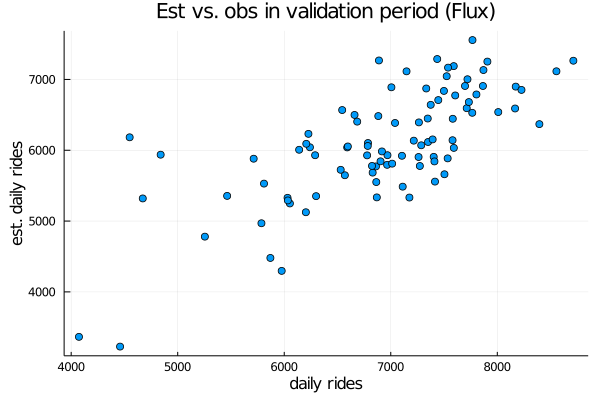

In [36]:
ŷvalf = max.(0.0,scale(Flux_nn(xvalScaledPca')',yScaleFactors,rev=true))
scatter(yval,ŷvalf,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in validation period (Flux)")

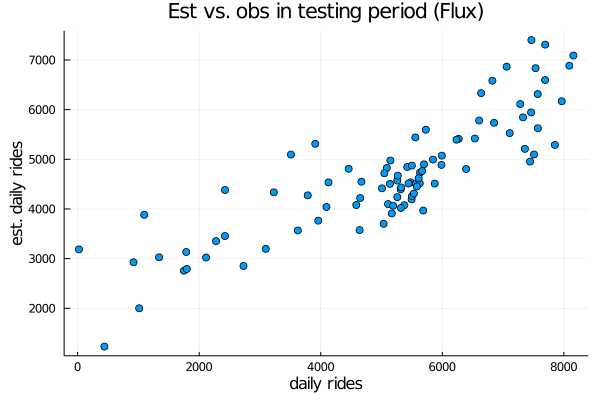

In [37]:
ŷtestf  = max.(0.0,scale(Flux_nn(xtestScaledPca')',yScaleFactors,rev=true))
scatter(ytest,ŷtestf,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in testing period (Flux)")

In [38]:
mean(abs.(ŷtestf .- ytest))/mean(ytest)

0.19868306161479676

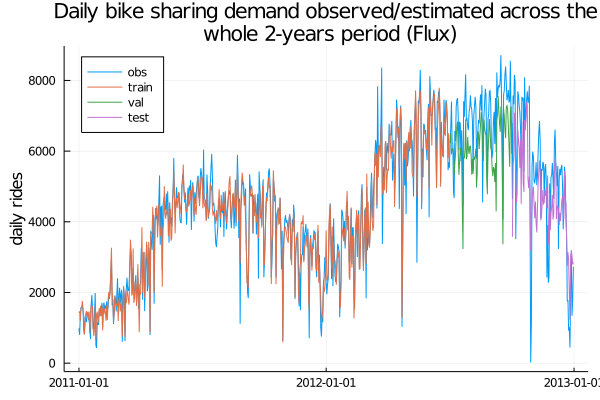

In [39]:
# Full period plot (2 years)
ŷtrainfullf = vcat(ŷtrainf,fill(missing,nval+ntest))
ŷvalfullf = vcat(fill(missing,ntrain), ŷvalf, fill(missing,ntest))
ŷtestfullf = vcat(fill(missing,ntrain+nval), ŷtestf)
plot(data[:,:dteday],[data[:,:cnt] ŷtrainfullf ŷvalfullf ŷtestfullf], label=["obs" "train" "val" "test"], legend=:topleft, ylabel="daily rides", title="Daily bike sharing demand observed/estimated across the\n whole 2-years period (Flux)")

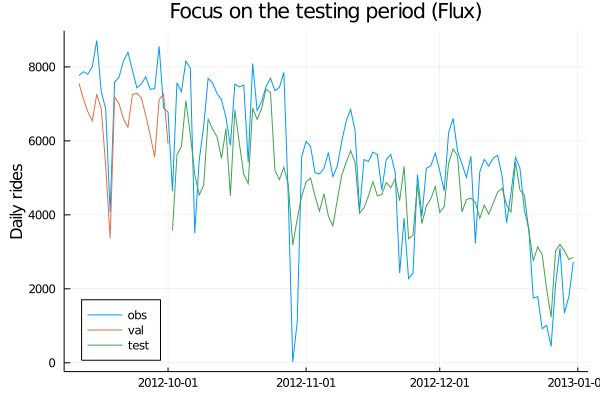

In [40]:
# Focus on testing data
stc = 620
endc = size(x,1)
plot(data[stc:endc,:dteday],[data[stc:endc,:cnt] ŷvalfullf[stc:endc] ŷtestfullf[stc:endc]], label=["obs" "val" "test"], legend=:bottomleft, ylabel="Daily rides", title="Focus on the testing period (Flux)")